In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform_mnist = transforms.Compose([transforms.ToTensor()])

train_data_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)

train_mnist, val_mnist= train_test_split(train_data_mnist, test_size=0.2, random_state=42)

train_loader_mnist = torch.utils.data.DataLoader(train_mnist, batch_size=64, shuffle=True, num_workers=2)
val_loader_mnist = torch.utils.data.DataLoader(val_mnist, batch_size=64, shuffle=True, num_workers=2)

test_data_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)
test_loader_mnist = torch.utils.data.DataLoader(test_data_mnist, batch_size=64, shuffle=False, num_workers=2)

In [4]:
test_labels = []
for i in test_data_mnist:
    test_labels.append(i[1])

In [5]:
loaders_mnist = {
    'train': train_loader_mnist,
    'val': val_loader_mnist,
    'test': test_loader_mnist
}

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.data = torch.tensor([])
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.FC1 = nn.Linear(32 * 7 * 7, 850)
        self.ReLU = nn.LeakyReLU(0.1)
        self.out = nn.Linear(850, 10)
    def forward(self, x, test=False):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        if test:
            self.data = torch.cat((self.data, x.detach()))
        x = self.FC1(x)
        x = self.ReLU(x)
        output = self.out(x)
        return output

In [7]:
def train(num_epochs, cnn, loaders):
    cnn.train()
    running_loss = 0.0
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, data in enumerate(loaders['train']):
            inputs, labels = data
            
            optimizer.zero_grad()
            
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

In [8]:
cnn_mnist = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_mnist.parameters(), lr = 1e-6)

num_epochs = 1
train(num_epochs, cnn_mnist, loaders_mnist)
torch.save(cnn_mnist.state_dict(), './cnn_mnist_small_lr.pth')

Epoch 1/1, Loss: 2.297710657119751
Epoch 1/1, Loss: 2.306198835372925
Epoch 1/1, Loss: 2.3009347915649414
Epoch 1/1, Loss: 2.308356523513794
Epoch 1/1, Loss: 2.297844171524048
Epoch 1/1, Loss: 2.30576229095459
Epoch 1/1, Loss: 2.3029329776763916


In [9]:
cnn_mnist = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_mnist.parameters(), lr = 1e-3)

num_epochs = 15
train(num_epochs, cnn_mnist, loaders_mnist)
torch.save(cnn_mnist.state_dict(), './cnn_mnist_large_lr.pth')

Epoch 1/15, Loss: 0.32819339632987976
Epoch 1/15, Loss: 0.18135206401348114
Epoch 1/15, Loss: 0.0398385189473629
Epoch 1/15, Loss: 0.11460283398628235
Epoch 1/15, Loss: 0.15046723186969757
Epoch 1/15, Loss: 0.07990998029708862
Epoch 1/15, Loss: 0.07937856763601303
Epoch 2/15, Loss: 0.01444518007338047
Epoch 2/15, Loss: 0.04170893877744675
Epoch 2/15, Loss: 0.011926393024623394
Epoch 2/15, Loss: 0.05505736172199249
Epoch 2/15, Loss: 0.029118582606315613
Epoch 2/15, Loss: 0.14860093593597412
Epoch 2/15, Loss: 0.02582164667546749
Epoch 3/15, Loss: 0.07579067349433899
Epoch 3/15, Loss: 0.0002825050032697618
Epoch 3/15, Loss: 0.02213316783308983
Epoch 3/15, Loss: 0.0020154165104031563
Epoch 3/15, Loss: 0.010974643751978874
Epoch 3/15, Loss: 0.010637604631483555
Epoch 3/15, Loss: 0.03248370438814163
Epoch 4/15, Loss: 0.029101597145199776
Epoch 4/15, Loss: 0.031180860474705696
Epoch 4/15, Loss: 0.009822607971727848
Epoch 4/15, Loss: 0.006764810066670179
Epoch 4/15, Loss: 0.05164588242769241
E

In [10]:
cnn_mnist_small_lr = CNN()
cnn_mnist_small_lr.load_state_dict(torch.load('./cnn_mnist_small_lr.pth'))
cnn_mnist_small_lr.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC1): Linear(in_features=1568, out_features=850, bias=True)
  (ReLU): LeakyReLU(negative_slope=0.1)
  (out): Linear(in_features=850, out_features=10, bias=True)
)

In [11]:
cnn_mnist_large_lr = CNN()
cnn_mnist_large_lr.load_state_dict(torch.load('./cnn_mnist_large_lr.pth'))
cnn_mnist_large_lr.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC1): Linear(in_features=1568, out_features=850, bias=True)
  (ReLU): LeakyReLU(negative_slope=0.1)
  (out): Linear(in_features=850, out_features=10, bias=True)
)

In [12]:
def test(model, loaders):
    true_labels=[]
    pred_labels=[]
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for i, data in enumerate(loaders['test'], 0):
            image, label = data
            pred = model(image, test=True)
            for i in range(len(data)):
                if torch.argmax(pred[i]) == label[i]:
                    correct += 1
                total += 1
    print(f"Acuracy: {round(correct/total*100, 2)}%")

In [13]:
test(cnn_mnist_small_lr, loaders_mnist)

Acuracy: 12.74%


In [14]:
test(cnn_mnist_large_lr, loaders_mnist)

Acuracy: 98.09%


In [15]:
copy_small_lr_data = cnn_mnist_small_lr.data

pca = PCA(n_components=2)
pca.fit(copy_small_lr_data)
small_lr_pca = pca.transform(copy_small_lr_data)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
small_lr_tsne = tsne.fit_transform(copy_small_lr_data)

C:\Users\thed7f\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\thed7f\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.022s...
[t-SNE] Computed neighbors for 10000 samples in 5.367s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.386474
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.077225
[t-SNE] KL divergence after 1000 iterations: 1.640419


In [16]:
copy_large_lr_data = cnn_mnist_large_lr.data

pca = PCA(n_components=2)
pca.fit(copy_large_lr_data)
large_lr_pca = pca.transform(copy_large_lr_data)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
large_lr_tsne = tsne.fit_transform(copy_large_lr_data)

C:\Users\thed7f\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\thed7f\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.050s...
[t-SNE] Computed neighbors for 10000 samples in 6.431s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.305197
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.690117
[t-SNE] KL divergence after 1000 iterations: 1.543896


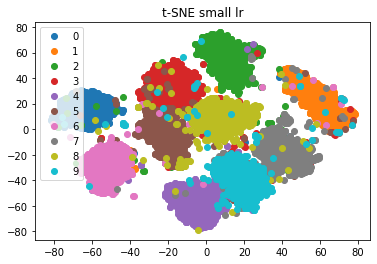

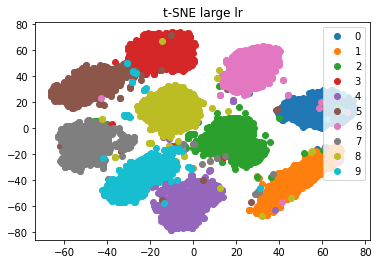

In [34]:
#t-SNE small lr
small_lr_df = pd.DataFrame(dict(x=small_lr_tsne[:, 0], y=small_lr_tsne[:, 1], label=test_labels))
groups = small_lr_df.groupby('label')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
ax.legend()
plt.title("t-SNE small lr")
plt.show()

#t-SNE large lr
large_lr_df = pd.DataFrame(dict(x=large_lr_tsne[:, 0], y=large_lr_tsne[:, 1], label=test_labels))
groups = large_lr_df.groupby('label')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
ax.legend()
plt.title("t-SNE large lr")
plt.show()


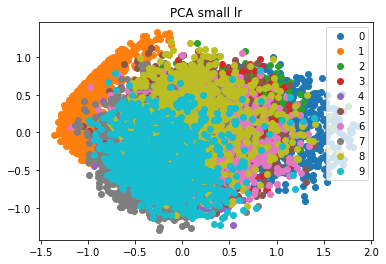

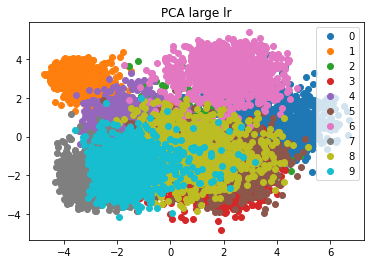

In [35]:
#PCA small lr
small_lr_df = pd.DataFrame(dict(x=small_lr_pca[:, 0], y=small_lr_pca[:, 1], label=test_labels))
groups = small_lr_df.groupby('label')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
    plt.title("PCA small lr")
ax.legend()
plt.show()

#PCA large lr
large_lr_df = pd.DataFrame(dict(x=large_lr_pca[:, 0], y=large_lr_pca[:, 1], label=test_labels))
groups = large_lr_df.groupby('label')

fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=6, label=name)
plt.title("PCA large lr")
ax.legend()
plt.show()